In [1]:
%pylab inline
import os, sys
import emcee
import yaml
import astropy.io.ascii as ascii
from scipy import ndimage
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import warnings
from functools import partial
import corner
from scipy.signal import savgol_filter
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
# from zg_utils import*
from astropy.modeling.functional_models import Sersic2D
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(Om0=0.3,H0=70)
import h5py
from scipy.ndimage import gaussian_filter

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

Text(0, 0.5, 'ratio')

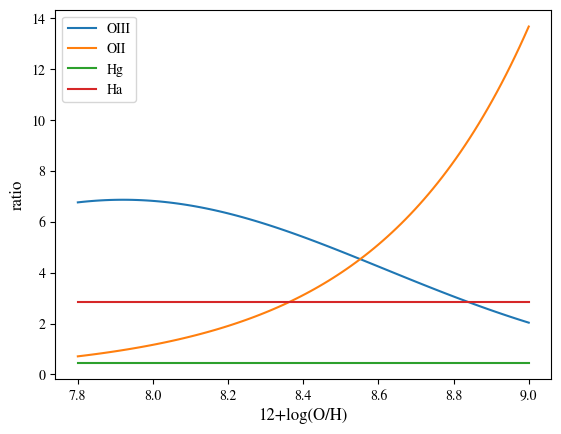

In [5]:
rootpath_caldb     = os.path.expanduser('')
fn_caldb           = 'calibr_sanders23.yml'

caldb = yaml.safe_load(open(os.path.join(rootpath_caldb, fn_caldb), 'r'))
oh12_norm = caldb['norm']
caldb_name = caldb['name'].replace('+','')
a = np.linspace(7.8,9,100)
plt.plot(a,10**np.polyval(caldb['OIII']['bestfit'][::-1],a),label='OIII')
plt.plot(a,10**np.polyval(caldb['OII']['bestfit'][::-1],a),label='OII')
plt.plot(a,10**np.polyval(caldb['Hg']['bestfit'][::-1],a),label='Hg')
plt.plot(a,10**np.polyval(caldb['Ha']['bestfit'][::-1],a),label='Ha')
plt.legend()
plt.xlabel('12+log(O/H)',fontsize=12)
plt.ylabel('ratio',fontsize=12)

In [7]:
# run z_mock.py to get the mock output z_mock_grid.npy
full_dic = np.load('z_mock_grid.npy',allow_pickle=True).item()
snr_arr = np.arange(2,22,1)
z_arr = np.arange(7.5,8.5,0.05)
Av_arr = np.arange(0,1.2,0.2)
d_z = z_arr[1] - z_arr[0]
d_snr = (snr_arr[1] - snr_arr[0])/2

In [8]:
from astropy.visualization import ImageNormalize, ZScaleInterval

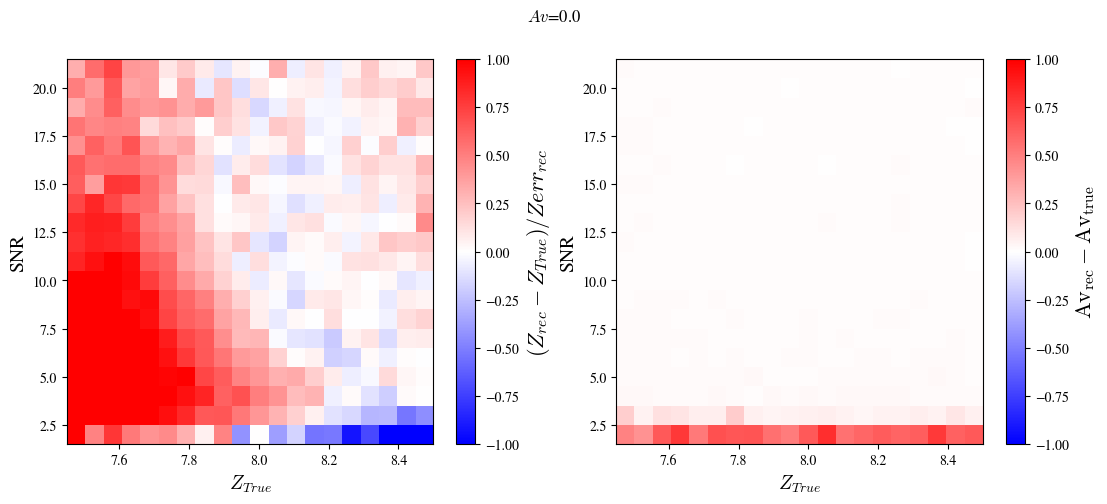

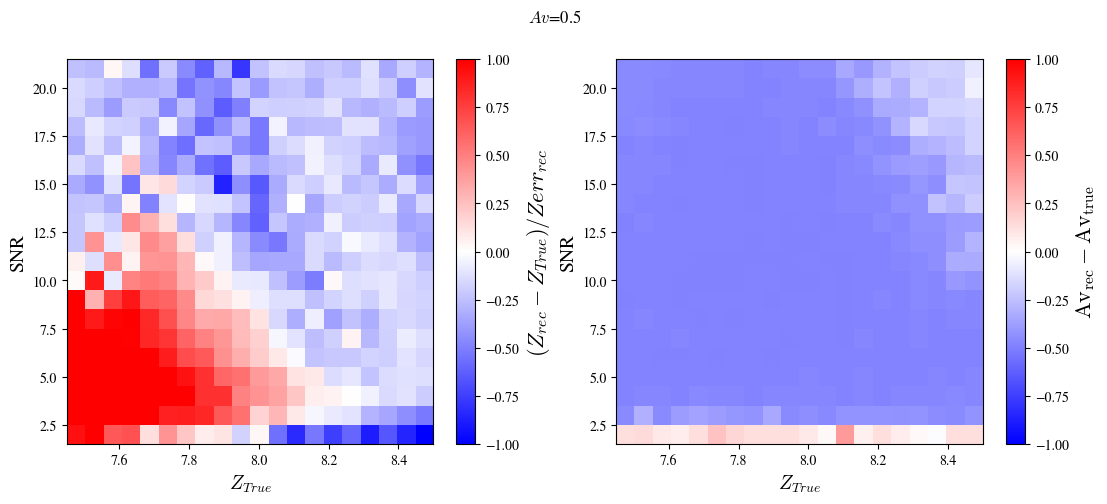

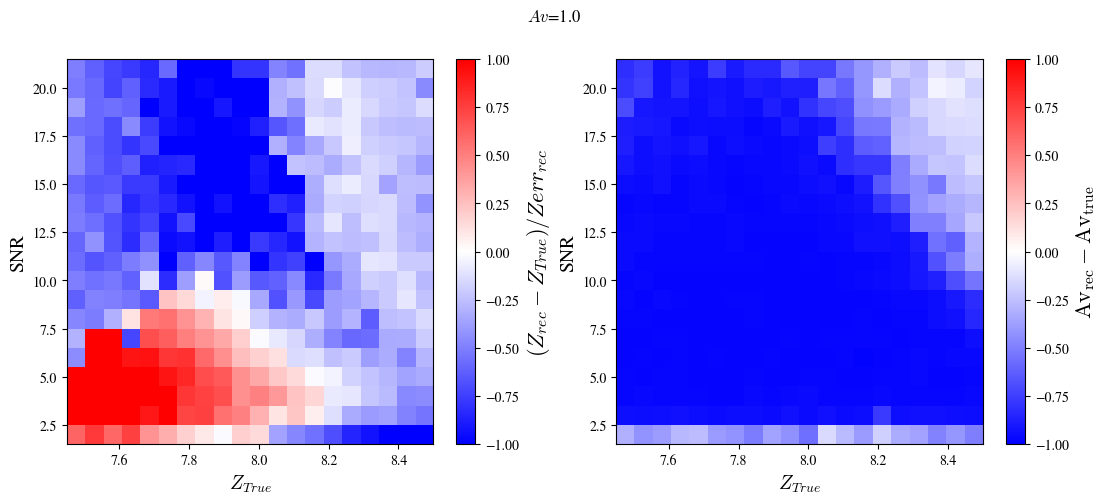

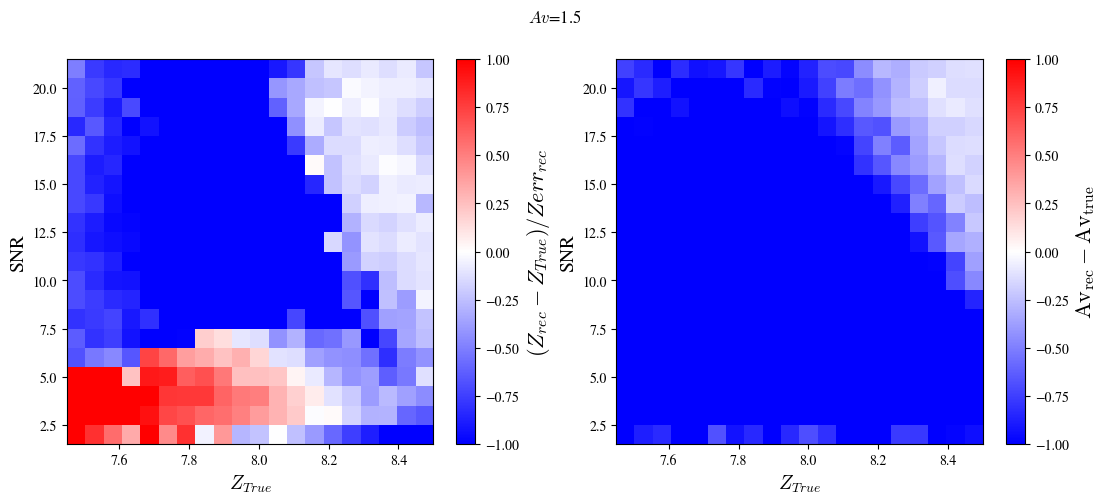

In [13]:
# show bf results
for Av_key in full_dic:
    this_dic = full_dic[Av_key]
    Av = Av_key.split('_')[1]
    z_diff = np.zeros(shape=(len(snr_arr),len(z_arr)))
    z_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    Av_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    err_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    for i,snr in enumerate(snr_arr):
        snr_key = f'snr_{snr}'
        for j,z in enumerate(z_arr):
            z_key = f'Z_{z:.2f}'
            data = this_dic[snr_key][z_key]['bf']
            err = np.median(this_dic[snr_key][z_key]['me_std'])
            z_med = np.nanmedian(data)
            z_l,z_u = np.nanquantile(data,[0.16,0.84])
            e_l = z_med - z_l
            e_u = z_u - z_med
            z_diff[i,j] = z_med - z
            z_rec[i,j] = z_med
            Av_rec[i,j] = np.nanmedian(this_dic[snr_key][z_key]['bf_Av'])
            err_rec[i,j] = err
            
    fig,ax = plt.subplots(1,2,figsize=(13,5))
    im = ax[0].imshow(z_diff/err_rec,extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
               aspect='auto',origin='lower',interpolation='None',cmap='bwr',vmin=-1,vmax=1)
    cb = plt.colorbar(im,ax=ax[0])
    cb.set_label(label=r'$(Z_{rec}-Z_{True})/Zerr_{rec}$',fontdict={'size':16})

    ax[0].set_xlabel('$Z_{True}$',fontsize=14)
    ax[0].set_ylabel('SNR',fontsize=14)
    plt.suptitle(f'$Av$={Av}')
    im = ax[1].imshow(Av_rec-float(Av),extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
               aspect='auto',origin='lower',interpolation='None',cmap='bwr',
                      # norm=norm,
                      vmin=-1,vmax=1
                     )
    ax[1].set_xlabel('$Z_{True}$',fontsize=14)
    ax[1].set_ylabel('SNR',fontsize=14)
    cb = plt.colorbar(im,ax=ax[1])
    cb.set_label(label=r'$\rm Av_{rec}-Av_{true}$',fontdict={'size':16})
    plt.show()

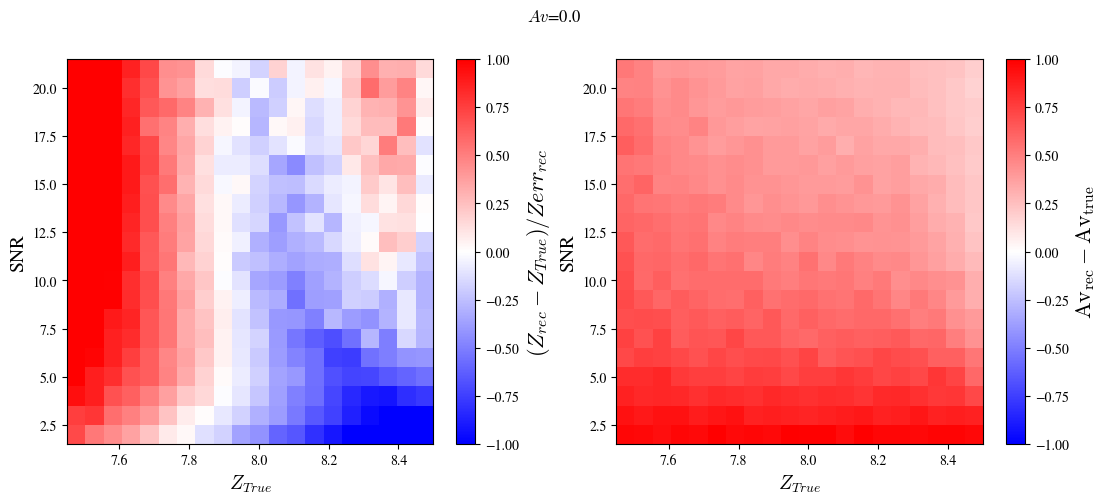

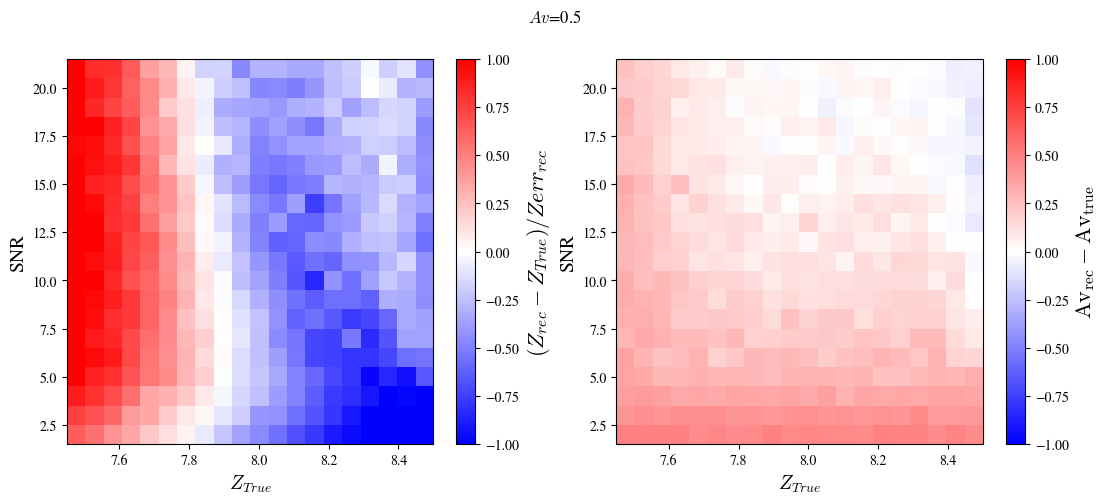

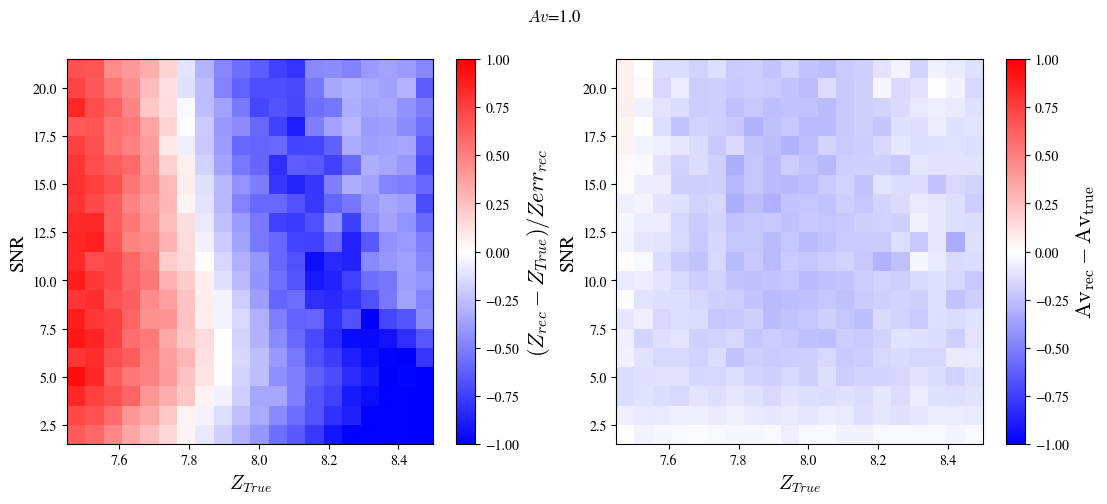

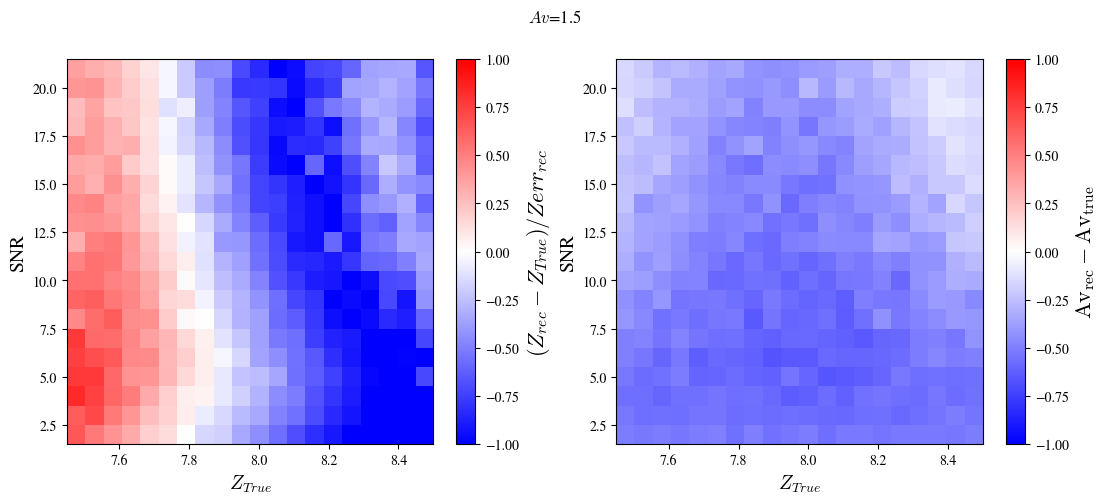

In [14]:
# show me results
for Av_key in full_dic:
    this_dic = full_dic[Av_key]
    Av = Av_key.split('_')[1]
    z_diff = np.zeros(shape=(len(snr_arr),len(z_arr)))
    z_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    Av_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    err_rec = np.zeros(shape=(len(snr_arr),len(z_arr)))
    for i,snr in enumerate(snr_arr):
        snr_key = f'snr_{snr}'
        for j,z in enumerate(z_arr):
            z_key = f'Z_{z:.2f}'
            data = this_dic[snr_key][z_key]['me']
            err = np.median(this_dic[snr_key][z_key]['me_std'])
            z_med = np.nanmedian(data)
            z_l,z_u = np.nanquantile(data,[0.16,0.84])
            e_l = z_med - z_l
            e_u = z_u - z_med
            z_diff[i,j] = z_med - z
            z_rec[i,j] = z_med
            Av_rec[i,j] = np.nanmedian(this_dic[snr_key][z_key]['me_Av'])
            err_rec[i,j] = err
            
    fig,ax = plt.subplots(1,2,figsize=(13,5))
    im = ax[0].imshow(z_diff/err_rec,extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
               aspect='auto',origin='lower',interpolation='None',cmap='bwr',vmin=-1,vmax=1)
    cb = plt.colorbar(im,ax=ax[0])
    cb.set_label(label=r'$(Z_{rec}-Z_{True})/Zerr_{rec}$',fontdict={'size':16})

    ax[0].set_xlabel('$Z_{True}$',fontsize=14)
    ax[0].set_ylabel('SNR',fontsize=14)
    plt.suptitle(f'$Av$={Av}')
    im = ax[1].imshow(Av_rec-float(Av),extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
               aspect='auto',origin='lower',interpolation='None',cmap='bwr',
                      # norm=norm,
                      vmin=-1,vmax=1
                     )
    ax[1].set_xlabel('$Z_{True}$',fontsize=14)
    ax[1].set_ylabel('SNR',fontsize=14)
    cb = plt.colorbar(im,ax=ax[1])
    cb.set_label(label=r'$\rm Av_{rec}-Av_{true}$',fontdict={'size':16})
    plt.show()